# Final Assignment

This is the notebook for the final assignment for **Data Science** Capstone.

## Introduction

A client is thinking of opening a new hotel in London. Since there are many hotels in London, we will try to locate them by their coordinates and we will be interested in areas with not so many hotels nearby. In addition, we would prefer to suggest locations as close to the city center as possible.

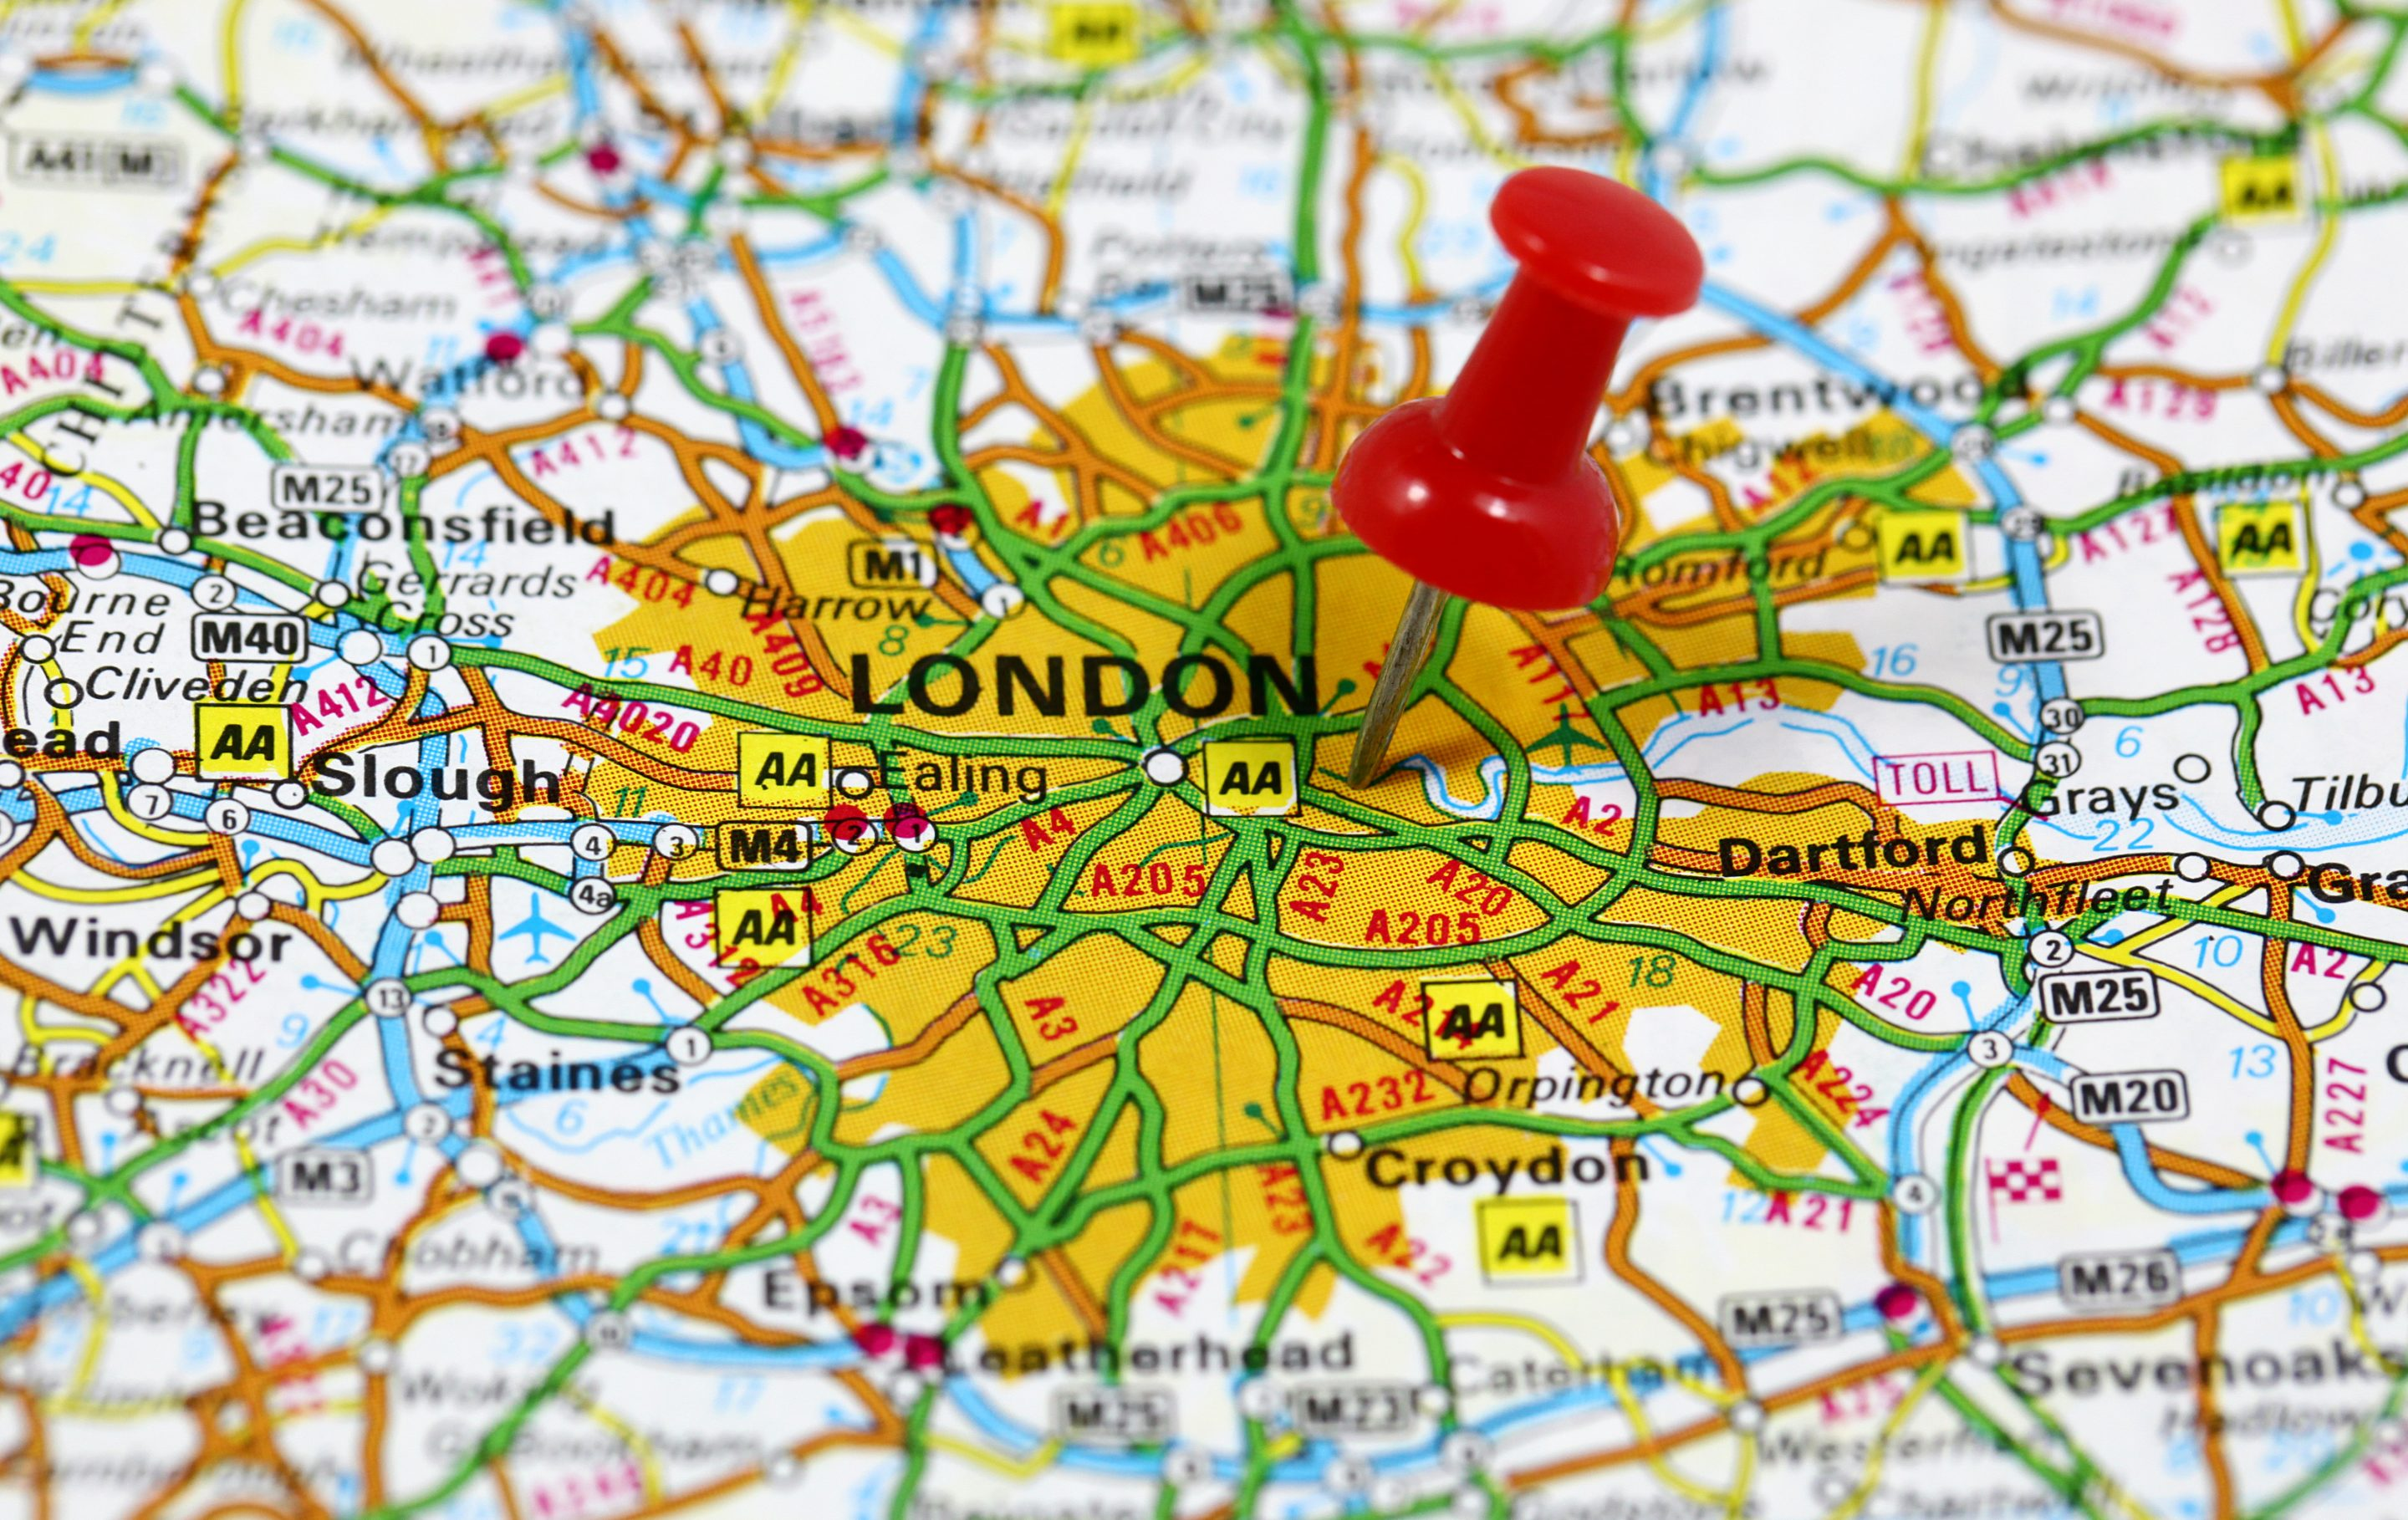

In [5]:
from IPython.core.display import Image, display
display(Image('https://coronerscourtssupportservice.org.uk/wp-content/uploads/2017/07/shutterstock_282233564.jpg', width=500))

!!!!!!!! 

## Table of contents
   1. <a href="#item1">Import the libraries</a>   
   2. <a href="#item2">Get the data for neighborhoods/areas of London and scrap them</a>
   3. [Get the geographical coordinates for each location of London, England, GBR](#3)<br>
   4. [Create a map of London with neighborhoods superimposed on top](#4)<br>
   5. [Use the Foursquare API to explore the neighborhoods](#5)<br>
   6. [Cluster neighborhoods](#6)<br>
   7. [Examine the clusters](#7)<br>
   8. [Conclusion](#8)<br>

---

##  1. Import the necessary libraries 

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install geocoder
import geocoder # to get coordinates

import requests # library to handle requests

!pip install BeautifulSoup4
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("Libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

---

## 2. Get the data for neighborhoods/areas of London and scrap them 


In [7]:
# import the library we use to open URLs
import urllib.request

In [8]:
# get the data from wikipedia
data = requests.get("https://en.wikipedia.org/wiki/List_of_areas_of_London").text

In [9]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

Looking through the output of soup ,  we can again see that the class id of our chosen table is ”wikitable sortable”. We can use this to get BeautifulSoup to only bring back the table data for this particular table and keep that in a variable called ”right_table“

In [10]:
right_table=soup.find("table", class_="wikitable sortable")

We know that the table is set up in rows (starting with <"tr"> tags) with the data sitting within <" td "> tags in each row.

To start with, we want to use the Beautiful Soup ‘find_all’ function again and set it to look for the string ‘tr’. We will then set up a FOR loop for each row within that array and set Python to loop through the rows, one by one.

Within the loop we are going to use find_all again to search each row for <'td'> tags with the ‘td’ string. We will add all of these to a variable called ‘cells’ and then check to make sure that there are 5 items in our ‘cells’ array (i.e. one for each column).

If there are then we use the find(text=True)) option to extract the content string from within each <td> element in that row and add them to the A-E lists we created at the start of this step. Let’s have a look at the code:

In [11]:
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]

for row in right_table.findAll('tr'):
    cells=row.findAll("td")
    
    if len(cells)== 6:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))
        F.append(cells[5].find(text=True))


In [12]:
# create a new DataFrame from the list
london_df = pd.DataFrame(A,columns=["Location"])
london_df['Region']=B
london_df['Post town']=C
london_df['Postcode district']=D
#london_df['Dial code']=E    <- We don't need this column
#london_df['OS grid ref']=F  <- We don't need this column

london_df.head(10)

Location                          Region       Post town  \
0        Abbey Wood             Bexley,  Greenwich           LONDON   
1             Acton  Ealing, Hammersmith and Fulham          LONDON   
2         Addington                         Croydon         CROYDON   
3        Addiscombe                         Croydon         CROYDON   
4       Albany Park                          Bexley  BEXLEY, SIDCUP   
5  Aldborough Hatch                       Redbridge          ILFORD   
6           Aldgate                            City          LONDON   
7           Aldwych                     Westminster          LONDON   
8          Alperton                           Brent         WEMBLEY   
9           Anerley                         Bromley          LONDON   

  Postcode district  
0               SE2  
1            W3, W4  
2               CR0  
3               CR0  
4         DA5, DA14  
5               IG2  
6               EC3  
7               WC2  
8               HA0  
9              SE20

In [13]:
print('The size of the dataframe london_df is {}'.format(london_df.shape))

The size of the dataframe london_df is (533, 4)


We notice that the column 'Post town' contains regions quite out of London and thus, we create a new dataframe excluding the rows of which the 'Post town' is not London.

In [14]:
df = london_df.loc[london_df['Post town'] == 'LONDON']
df.reset_index(drop=True,inplace=True)
df.head(50)

Location                          Region Post town  \
0                  Abbey Wood             Bexley,  Greenwich     LONDON   
1                       Acton  Ealing, Hammersmith and Fulham    LONDON   
2                     Aldgate                            City    LONDON   
3                     Aldwych                     Westminster    LONDON   
4                     Anerley                         Bromley    LONDON   
5                       Angel                       Islington    LONDON   
6                     Archway                       Islington    LONDON   
7                 Arnos Grove                         Enfield    LONDON   
8                      Balham                      Wandsworth    LONDON   
9                    Bankside                       Southwark    LONDON   
10                   Barbican                            City    LONDON   
11                     Barnes            Richmond upon Thames    LONDON   
12                  Barnsbury                       Islington    LONDON   
13                  Battersea                      Wandsworth    LONDON   
14                  Bayswater                     Westminster    LONDON   
15               Bedford Park                          Ealing    LONDON   
16                  Belgravia                     Westminster    LONDON   
17                 Bellingham                        Lewisham    LONDON   
18               Belsize Park                          Camden    LONDON   
19                 Bermondsey                       Southwark    LONDON   
20              Bethnal Green                   Tower Hamlets    LONDON   
21                Blackfriars                            City    LONDON   
22                 Blackheath                        Lewisham    LONDON   
23  Blackheath Royal Standard                       Greenwich    LONDON   
24                  Blackwall                   Tower Hamlets    LONDON   
25                 Bloomsbury                          Camden    LONDON   
26               Bounds Green                        Haringey    LONDON   
27                        Bow                   Tower Hamlets    LONDON   
28                 Bowes Park                        Haringey    LONDON   
29                Brent Cross                          Barnet    LONDON   
30                 Brent Park                           Brent    LONDON   
31                    Brixton                         Lambeth    LONDON   
32                   Brockley                        Lewisham    LONDON   
33                    Bromley                   Tower Hamlets    LONDON   
34                   Brompton          Kensington and Chelsea    LONDON   
35                Brondesbury                           Brent    LONDON   
36             Brunswick Park                          Barnet    LONDON   
37             Burroughs, The                          Barnet    LONDON   
38                 Camberwell                       Southwark    LONDON   
39            Cambridge Heath                   Tower Hamlets    LONDON   
40                Camden Town                          Camden    LONDON   
41               Canary Wharf                   Tower Hamlets    LONDON   
42                  Cann Hall                  Waltham Forest    LONDON   
43               Canning Town                          Newham    LONDON   
44                  Canonbury                       Islington    LONDON   
45                  Castelnau            Richmond upon Thames    LONDON   
46                    Catford                        Lewisham    LONDON   
47                 Chalk Farm                          Camden    LONDON   
48              Charing Cross                     Westminster    LONDON   
49                   Charlton                       Greenwich    LONDON   

   Postcode district  
0                SE2  
1             W3, W4  
2                EC3  
3                WC2  
4               SE20  
5            EC1, N1  
6                N19  
7          

In [15]:
print('The size of the dataframe df is {}'.format(london_df.shape))

The size of the dataframe df is (533, 4)


---
## 3. Get the geographical coordinates for each location of London, England, GBR <a name="3" ></a>

In [16]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, England, GBR'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [17]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["Location"].tolist() ]
coords

[[51.492450000000076, 0.12127000000003818],
 [51.51324000000005, -0.2674599999999714],
 [51.513308435920024, -0.077762090020195],
 [51.513306704512985, -0.11709219462088734],
 [51.412330000000054, -0.06538999999997941],
 [51.45302000000004, -0.06339999999994461],
 [51.56574690648617, -0.13491918108038964],
 [51.62243647082235, -0.1272340503978188],
 [51.44822000000005, -0.1483899999999494],
 [51.50760000000008, -0.09324999999995498],
 [51.52005005107048, -0.09247002452461052],
 [51.47457000000003, -0.24211999999994305],
 [51.536480534879935, -0.1109095599068421],
 [51.46760000000006, -0.16289999999997917],
 [51.51048000000003, -0.18425999999993792],
 [51.51906000000008, -0.1289499999999748],
 [51.49705000000006, -0.15274999999996908],
 [51.6023285115412, -0.055862612268439395],
 [51.546898398855184, -0.17282773457354447],
 [51.49790000000007, -0.08143999999992957],
 [51.52669000000003, -0.06256999999993695],
 [51.51204000000007, -0.10355999999995902],
 [51.47138000000007, 0.02338000000

In [18]:
# create temporary dataframe to insert the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_coords.head()

Latitude  Longitude
0  51.492450   0.121270
1  51.513240  -0.267460
2  51.513308  -0.077762
3  51.513307  -0.117092
4  51.412330  -0.065390

In [19]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

# show only the columns 'Location', 'Latitude' and 'Longitude'
df = df[['Location','Latitude','Longitude']]
df.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Location   Latitude  Longitude
0   Abbey Wood  51.492450   0.121270
1        Acton  51.513240  -0.267460
2      Aldgate  51.513308  -0.077762
3      Aldwych  51.513307  -0.117092
4      Anerley  51.412330  -0.065390
5        Angel  51.453020  -0.063400
6      Archway  51.565747  -0.134919
7  Arnos Grove  51.622436  -0.127234
8       Balham  51.448220  -0.148390
9     Bankside  51.507600  -0.093250

In [20]:
# save the DataFrame as CSV file
df.to_csv("df.csv", index=False)
print("The dataframe was saved in CSV file.")

The dataframe was saved in CSV file.


---

## 4. Create a map of London with neighborhoods superimposed on top <a name="4" ></a>

In [21]:
# get the coordinates of London
address = 'London, England'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London, England are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London, England are 51.5073219, -0.1276474.


In [22]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=12)

# add a red circle marker to represent the London center
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='London center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_london)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
    ).add_to(map_london)  
    
map_london

In [23]:
# save the map as HTML file
map_london.save('map_london.html')
print("The map was saved as a HTML file.")

The map was saved as a HTML file.


---

## 5. Use the Foursquare API to explore the neighborhoods <a name="5" ></a>

In [24]:
# define the Foursquare credentials
CLIENT_ID = 'NWA3WYGNW1YEFCGFOCHEQTMIJIUSOLHM33USSHV2WT4MP5AG' # your Foursquare ID
CLIENT_SECRET = 'WQRZFJEPPLROHNLVNSHI3BPF0YDATBTK4DOBU5ITYXABP5CU' # your Foursquare Secret
VERSION = '20190810'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentials:
CLIENT_ID: NWA3WYGNW1YEFCGFOCHEQTMIJIUSOLHM33USSHV2WT4MP5AG
CLIENT_SECRET:WQRZFJEPPLROHNLVNSHI3BPF0YDATBTK4DOBU5ITYXABP5CU


Now, let's get the top 30 venues of category 'Hotel' that are within a radius of 2000 meters.

In [25]:
radius=2000
limit=30
category_id='4bf58dd8d48988d1fa931735' #this is the category id for 'Hotel'


hotels_list=[]

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location']):

    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}&radius={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        lat,
        long,
        VERSION,
        category_id,
        limit,
        radius
        )

    result = requests.get(url).json()["response"]['venues']
 
    for r in result:
        hotels_list.append((
            neighborhood,
            lat, 
            long, 
            r['name'], 
            r['location']['lat'], 
            r['location']['lng'],  
            r['categories'][0]['name']
        ))

In [26]:
# convert the list of hotels into a new DataFrame
hotels_df = pd.DataFrame(hotels_list)
# define the column names
hotels_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print("The shape of the dataframe is {}".format(hotels_df.shape))
hotels_df.head(10)

The shape of the dataframe is (6477, 7)


Neighborhood  Latitude  Longitude                                VenueName  \
0   Abbey Wood  51.49245    0.12127                        Simply Guesthouse   
1        Acton  51.51324   -0.26746                       London Guest House   
2        Acton  51.51324   -0.26746                             A to Z Hotel   
3        Acton  51.51324   -0.26746           Premier Inn London Hanger Lane   
4        Acton  51.51324   -0.26746  Holiday Inn Express London - Park Royal   
5        Acton  51.51324   -0.26746                Holiday Inn London - West   
6        Acton  51.51324   -0.26746                     DoubleTree by Hilton   
7        Acton  51.51324   -0.26746                    Park Plaza Park Royal   
8        Acton  51.51324   -0.26746                         Sani House Hotel   
9        Acton  51.51324   -0.26746                                Waytostay   

   VenueLatitude  VenueLongitude    VenueCategory  
0      51.491974        0.115207            Hotel  
1      51.513973       -0.269680  Bed & Breakfast  
2      51.514259       -0.268950            Hotel  
3      51.513120       -0.292570            Hotel  
4      51.523044       -0.259389            Hotel  
5      51.520993       -0.262854            Hotel  
6      51.511834       -0.290615            Hotel  
7      51.527268       -0.283010            Hotel  
8      51.506718       -0.244632  Bed & Breakfast  
9      51.524207       -0.261332            Hotel

### The above dataframe was created by searching for 'Hotel' category. 
#### However, the category id which was used for this search was the root category and there are subcategories such as hostels, motels or appartments.

#### Let's check the number of venues per subcategory using **value_counts()**

In [27]:
hotels_df['VenueCategory'].value_counts()

Hotel                                       4543
Bed & Breakfast                              732
Hostel                                       504
Pub                                          210
Boarding House                               131
Resort                                        86
Vacation Rental                               85
Social Club                                   39
Bar                                           34
Residential Building (Apartment / Condo)      28
Gastropub                                     27
Motel                                         22
Modern European Restaurant                    15
Hotel Pool                                     7
Inn                                            6
Gym / Fitness Center                           6
Doctor's Office                                1
Spiritual Center                               1
Name: VenueCategory, dtype: int64

#### Now, we will create a new dataframe for Hotel only and it will be named as **hotels_only_df**

In [28]:
hotels_only_df= hotels_df[hotels_df['VenueCategory']=='Hotel'].reset_index(drop=True)
print("The shape of hotels_only_df dataframe is {}".format(hotels_only_df.shape))
hotels_only_df.head(10)

The shape of hotels_only_df dataframe is (4543, 7)


Neighborhood  Latitude  Longitude                                VenueName  \
0   Abbey Wood  51.49245    0.12127                        Simply Guesthouse   
1        Acton  51.51324   -0.26746                             A to Z Hotel   
2        Acton  51.51324   -0.26746           Premier Inn London Hanger Lane   
3        Acton  51.51324   -0.26746  Holiday Inn Express London - Park Royal   
4        Acton  51.51324   -0.26746                Holiday Inn London - West   
5        Acton  51.51324   -0.26746                     DoubleTree by Hilton   
6        Acton  51.51324   -0.26746                    Park Plaza Park Royal   
7        Acton  51.51324   -0.26746                                Waytostay   
8        Acton  51.51324   -0.26746                               AtoB Hotel   
9        Acton  51.51324   -0.26746                  Travelodge London Acton   

   VenueLatitude  VenueLongitude VenueCategory  
0      51.491974        0.115207         Hotel  
1      51.514259       -0.268950         Hotel  
2      51.513120       -0.292570         Hotel  
3      51.523044       -0.259389         Hotel  
4      51.520993       -0.262854         Hotel  
5      51.511834       -0.290615         Hotel  
6      51.527268       -0.283010         Hotel  
7      51.524207       -0.261332         Hotel  
8      51.511868       -0.291205         Hotel  
9      51.522413       -0.256363         Hotel

### The number of hotels for each neighborhood.

In [29]:
hotels_only_grouped = hotels_only_df.groupby(['Neighborhood']).count().reset_index()
hotels_only_grouped.rename(columns={"VenueCategory":"TotalHotels"},inplace=True)
hotels_only_grouped= hotels_only_grouped[['Neighborhood','TotalHotels']]
print("The dataframe hotels_only_grouped is of shape: {}".format(hotels_only_grouped.shape))
hotels_only_grouped.head(20)

The dataframe hotels_only_grouped is of shape: (296, 2)


Neighborhood  TotalHotels
0     Abbey Wood            1
1          Acton           20
2        Aldgate           24
3        Aldwych           24
4        Anerley            2
5          Angel            3
6        Archway           13
7    Arnos Grove            5
8         Balham           12
9       Bankside           23
10      Barbican           26
11        Barnes           14
12     Barnsbury           26
13     Battersea           20
14     Bayswater           28
15  Bedford Park           26
16     Belgravia           27
17    Bellingham            3
18  Belsize Park           13
19    Bermondsey           22

In [30]:
hotels_only_grouped.mean()

TotalHotels    15.347973
dtype: float64

In [31]:
hotels_only_df.head(10)

Neighborhood  Latitude  Longitude                                VenueName  \
0   Abbey Wood  51.49245    0.12127                        Simply Guesthouse   
1        Acton  51.51324   -0.26746                             A to Z Hotel   
2        Acton  51.51324   -0.26746           Premier Inn London Hanger Lane   
3        Acton  51.51324   -0.26746  Holiday Inn Express London - Park Royal   
4        Acton  51.51324   -0.26746                Holiday Inn London - West   
5        Acton  51.51324   -0.26746                     DoubleTree by Hilton   
6        Acton  51.51324   -0.26746                    Park Plaza Park Royal   
7        Acton  51.51324   -0.26746                                Waytostay   
8        Acton  51.51324   -0.26746                               AtoB Hotel   
9        Acton  51.51324   -0.26746                  Travelodge London Acton   

   VenueLatitude  VenueLongitude VenueCategory  
0      51.491974        0.115207         Hotel  
1      51.514259       -0.268950         Hotel  
2      51.513120       -0.292570         Hotel  
3      51.523044       -0.259389         Hotel  
4      51.520993       -0.262854         Hotel  
5      51.511834       -0.290615         Hotel  
6      51.527268       -0.283010         Hotel  
7      51.524207       -0.261332         Hotel  
8      51.511868       -0.291205         Hotel  
9      51.522413       -0.256363         Hotel

### We will rename the column in df in order to avoid the confusion between 'Neighborhood' and 'Location'

In [32]:
df.rename(columns={"Location":"Neighborhood"},inplace=True)
df.head()

Neighborhood   Latitude  Longitude
0   Abbey Wood  51.492450   0.121270
1        Acton  51.513240  -0.267460
2      Aldgate  51.513308  -0.077762
3      Aldwych  51.513307  -0.117092
4      Anerley  51.412330  -0.065390

### We will then create a new dataframe which is merged between **hotels_only_grouped** and **df** and it shows the total number of hotels in each neighborhood .

In [33]:
hotels = pd.merge(hotels_only_grouped,df,on=['Neighborhood'])
hotels.head(10)

Neighborhood  TotalHotels   Latitude  Longitude
0   Abbey Wood            1  51.492450   0.121270
1        Acton           20  51.513240  -0.267460
2      Aldgate           24  51.513308  -0.077762
3      Aldwych           24  51.513307  -0.117092
4      Anerley            2  51.412330  -0.065390
5        Angel            3  51.453020  -0.063400
6      Archway           13  51.565747  -0.134919
7  Arnos Grove            5  51.622436  -0.127234
8       Balham           12  51.448220  -0.148390
9     Bankside           23  51.507600  -0.093250

---
## 6. Cluster neighborhoods <a name="6" ></a>

We will use clustering of data using *k*-means clustering algorithm.

In [34]:
# set number of clusters
kclusters = 5

london_clustering = hotels_only_grouped.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 2, 2, 4, 4, 3, 4, 3, 2], dtype=int32)

In [35]:
# create a new dataframe that includes the clusters
london_merged = hotels_only_grouped.copy()

# add clustering labels
london_merged["Cluster Labels"] = kmeans.labels_

In [36]:
london_merged.head(10)

Neighborhood  TotalHotels  Cluster Labels
0   Abbey Wood            1               4
1        Acton           20               0
2      Aldgate           24               2
3      Aldwych           24               2
4      Anerley            2               4
5        Angel            3               4
6      Archway           13               3
7  Arnos Grove            5               4
8       Balham           12               3
9     Bankside           23               2

In [37]:
# merge london_merged with hotels to add latitude/longitude for each neighborhood
london = london_merged.merge(hotels, on="Neighborhood")

print(london.shape)
london.head()

(298, 6)


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
0   Abbey Wood              1               4              1  51.492450   
1        Acton             20               0             20  51.513240   
2      Aldgate             24               2             24  51.513308   
3      Aldwych             24               2             24  51.513307   
4      Anerley              2               4              2  51.412330   

   Longitude  
0   0.121270  
1  -0.267460  
2  -0.077762  
3  -0.117092  
4  -0.065390

NOTE: <font color=red> *For some reason, two columns were added to the above dataframe as _x & _y*</font>

In [38]:
# sort the results by Cluster Labels
print(london.shape)
london.sort_values(["Cluster Labels"], inplace=True)
london.head()

(298, 6)


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
148     Leamouth             21               0             21  51.511058   
152  Leytonstone             19               0             19  51.547860   
151       Leyton             18               0             18  51.558850   
146      Lambeth             21               0             21  51.490840   
135   Kennington             20               0             20  51.487010   

     Longitude  
148   0.000461  
152   0.005764  
151  -0.007330  
146  -0.111080  
135  -0.113120

### We will then visualize the resulting clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london['Latitude'], london['Longitude'], london['Neighborhood'], london['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

---
## 7. Examine the clusters <a name="7" ></a>

#### We will then display the first 5 rows of each cluster

In [41]:
from IPython.display import display

i=0
while i<kclusters:
    cluster_i = london.loc[london['Cluster Labels'] == i]
    print("---------------------------- Cluster {} ----------------------------".format(i+1))
    display(cluster_i.head())
    print("-------------------------------------------------------------------")
    i=i+1

---------------------------- Cluster 1 ----------------------------


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
148     Leamouth             21               0             21  51.511058   
152  Leytonstone             19               0             19  51.547860   
151       Leyton             18               0             18  51.558850   
146      Lambeth             21               0             21  51.490840   
135   Kennington             20               0             20  51.487010   

     Longitude  
148   0.000461  
152   0.005764  
151  -0.007330  
146  -0.111080  
135  -0.113120

-------------------------------------------------------------------
---------------------------- Cluster 2 ----------------------------


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
261      Tulse Hill              8               1              8  51.444650   
254     Tooting Bec              8               1              8  51.430055   
116         Hanwell             10               1             10  51.508780   
227  South Woodford              8               1              8  51.589770   
262   Turnpike Lane              8               1              8  51.589440   

     Longitude  
261  -0.111330  
254  -0.134421  
116  -0.336300  
227   0.030520  
262  -0.107654

-------------------------------------------------------------------
---------------------------- Cluster 3 ----------------------------


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y  Latitude  \
25    Bloomsbury             25               2             25  51.52074   
214     Shadwell             23               2             23  51.51111   
149          Lee             26               2             26  51.51300   
16     Belgravia             27               2             27  51.49705   
237   St Pancras             28               2             28  51.52811   

     Longitude  
25    -0.12310  
214   -0.05675  
149   -0.13864  
16    -0.15275  
237   -0.12524

-------------------------------------------------------------------
---------------------------- Cluster 4 ----------------------------


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
6          Archway             13               3             13  51.565747   
240      Stockwell             14               3             14  51.470010   
211       Selhurst             15               3             15  51.391970   
238  Stamford Hill             14               3             14  51.570230   
232       St Giles             14               3             14  51.475560   

     Longitude  
6    -0.134919  
240  -0.112490  
211  -0.087750  
238  -0.072830  
232  -0.085091

-------------------------------------------------------------------
---------------------------- Cluster 5 ----------------------------


Neighborhood  TotalHotels_x  Cluster Labels  TotalHotels_y   Latitude  \
229  Southfields              5               4              5  51.594711   
93   Forest Gate              4               4              4  51.586637   
139    Kidbrooke              5               4              5  51.458940   
168    Mill Hill              3               4              3  51.615680   
87        Eltham              1               4              1  51.451180   

     Longitude  
229  -0.231523  
93   -0.252178  
139   0.026350  
168  -0.245110  
87    0.050300

-------------------------------------------------------------------


In [180]:
hotels=hotels_only_df[['VenueLatitude','VenueLongitude']]
hotels.head()

VenueLatitude  VenueLongitude
0      51.491974        0.115207
1      51.514259       -0.268950
2      51.513120       -0.292570
3      51.523044       -0.259389
4      51.520993       -0.262854

### Heat Map of the hotels according to their locations

In [181]:
# The locations of London have been added to the following line in order to generate a map based on these coordinates and then add each hotel
m = folium.Map([51.5073219, -0.1276474], zoom_start=11)

for index, row in hotels.iterrows():
    folium.CircleMarker([row['VenueLatitude'], row['VenueLongitude']],
                        radius=15,
                        #popup=row['VenueName'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

In [182]:
hotelsArray = hotels.values.tolist()

# plot heatmap
m.add_child(folium.plugins.HeatMap(hotelsArray, radius=10))
m

In [188]:
# save the above map as HTML file
m.save('heatmap_of_hotels_in_london.html')
print("Saved")

Saved


We will calculate the mean of the hotels per cluster.

In [205]:
from IPython.display import display

i=0
while i<kclusters:
    cluster_i = london.loc[london['Cluster Labels'] == i]
    print("---------------------- Cluster {} ----------------------------------".format(i+1))
    display("The mean of the hotels which are in cluster {} is: {}".format(i+1,cluster_i['TotalHotels_x'].mean()))
    print("")
    i=i+1

---------------------- Cluster 1 ----------------------------------


'The mean of the hotels which are in cluster 1 is: 19.942857142857143'


---------------------- Cluster 2 ----------------------------------


'The mean of the hotels which are in cluster 2 is: 7.604651162790698'


---------------------- Cluster 3 ----------------------------------


'The mean of the hotels which are in cluster 3 is: 25.366197183098592'


---------------------- Cluster 4 ----------------------------------


'The mean of the hotels which are in cluster 4 is: 14.306451612903226'


---------------------- Cluster 5 ----------------------------------


'The mean of the hotels which are in cluster 5 is: 3.3846153846153846'

---

## 8. Conclusion <a name="8" ></a>

The purpose of this project was to identify neighborhoods in London and then explore the hotels and their exact locations. Clustering of those locations was then performed in order to create major zones of interest. 

Keeping this in mind, we noticed after many trials that the k-means algorithm has better performance for creating 5 clusters to the neighborhoods of London. 

The neighborhoods of cluster 5 has the lowest number of hotels (mean= ~ 3 hotels) while the clusters 3 and 1 are the most crowded neighborhoods according to Hotel venues added in Foursquare API from which the exact coordinates have been exported. Regarding the cluster 3 of which the mean of hotels is ~25 hotels, it is very risky to open a new hotel because the number of already existing hotels is high. The less lower risky is the neighborhoods in cluster 1 which contains approximately 20 hotels.

In addition, the heatmap would be better to be examined thoroughly to locate the most suitable and optimal location.

The final decision for the optimal location for a new hotel will be made by the client based on specific characteristics of neighborhoods and distances from special locations, such as landmarks, airports, train and/or tube stations, as well as museums and restaurants. In general, the distances from the points of interest are actually factors of attractiveness of each location.

Finally, there is no doubt that further analysis has to be taken place considering the number of stars of the hotel that the client is thinking to open, by collecting the relevant data for the hotel categories by stars. In that case, probably data from *booking.com* could be retrieved for further analysis and evaluation.